# Imbalance IDM Treatment

Proses balancing data dievaluasi dengan menggunakan model densenet121dengan input di tingkat desa. Hasil proses tersebut dapat dilihat pada Tabel 3. Pada tabel tersebut dapat dilihat pros dan cons setiap proses penyeimbangan data. Class merge dipilih sebagai perlakuan untuk mengatasi ketidakseimbangan data dikarenakan metode tersebut memberikan tingkat akurasi paling baik dan seimbang dengan trade-off berkurangnya informasi yang bisa dikumpulkan dari hasil klasifikasi. Proses class merging dilakukan dengan menggabungkan dua kelas ekstrem ke kelas di dekatnya sehingga dari empat kelas IDM diubah menjadi dua kelas ( Maju Mandiri dan Tertinggal Berkembang). Distribusi data setelah dilakukan class merging dapat dilihat pada Gambar 14.

![image.png](attachment:950f1e12-7fd1-43cb-b70c-7d31e7db0e18.png)

### Import Library

In [1]:
import fastai
from fastai.vision.all import *


In [2]:
import os
from PIL import Image
import pandas as pd
import shutil

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
from sklearn.model_selection import StratifiedKFold

In [4]:
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/dataset/IDM/00. IDM Two Class Sentinel 10m TC.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [5]:
local_zip = '/content/drive/MyDrive/Colab Notebooks/dataset/IDM/00. Desa Sentinel 10m TC.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
def plot_multroc(tst_preds, k =5):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots( figsize=(9,7))
    for i in range(0,k):
        fpr, tpr, thresholds = metrics.roc_curve(tst_preds[i][1], tst_preds[i][0][:,1])
        roc_auc = metrics.auc(fpr, tpr)
        viz = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name="ROC fold {}".format(i))
        viz.plot(ax = ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.35,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")

    plt.show()

#### Preprocessing

In [5]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/general desa sentinel 10m tc/"
destpath = 'C:/Users/jwst2/Python/tesis/jpg/IDM/00. Desa Sentinel 10m TC'

### Imbalanced Dataset Control

In [7]:
path = Path.cwd() / ("00. Desa Sentinel 10m TC")

In [8]:
Path.BASE_PATH = path
path.ls()

(#4) [Path('BERKEMBANG'),Path('TERTINGGAL'),Path('MANDIRI'),Path('MAJU')]

In [9]:
fname = (path/"BERKEMBANG").ls()[0]
fname

Path('BERKEMBANG/3208071004.jpg')

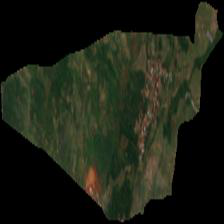

In [10]:
img = Image.open(fname)
img

In [11]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(0.1,seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label) # data augmentation (mult multiplies the default transformation values)

In [12]:
dls = blocks.dataloaders(path,bs= 10)

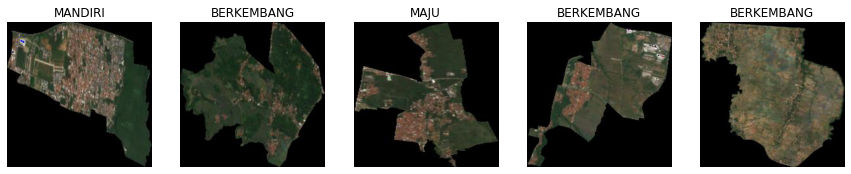

In [13]:
dls.show_batch(nrows=1, ncols=5)

#### Densenet Imbalance

In [14]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metricsc=[accuracy,bc, Precision(), Recall(),Recall(pos_label=0), f1s, roca]


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513)

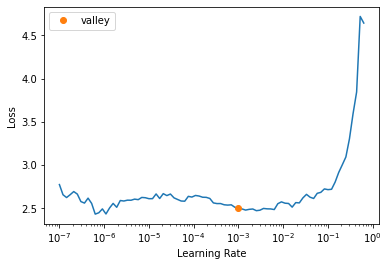

In [15]:
learn = vision_learner(dls, densenet121, metrics=metricsc) 
learn.lr_find()

In [21]:

bc = BalancedAccuracy()
metricsc=[accuracy,bc]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_labels = L(dls.train.items).map(dls.tfms[1])
valid_labels = L(dls.valid.items).map(dls.tfms[1])
train_labels = train_labels +valid_labels
train_imgs = dls.train.items
tst_imgs = dls.valid.items
val_pct = []
tst_preds = []
test_lab = []
for train_idx, val_idx in kf.split(np.array(train_imgs+tst_imgs), train_labels):
    blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=IndexSplitter(val_idx),  # default random split 80% training, 20% validation
                 get_y=parent_label) # data augmentation (mult multiplies the default transformation values)
    dls = blocks.dataloaders(path)
    learn = vision_learner(dls, densenet121, metrics=metricsc) 
    learn.fit_one_cycle(4,1e-2)
    val_pct.append(learn.validate())
    tst_preds.append(learn.get_preds(ds_idx=1))


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.624287,0.887227,0.570085,0.292012,00:26
1,1.179209,0.908596,0.610536,0.315665,00:25
2,0.995429,0.799984,0.646284,0.306818,00:25
3,0.884268,0.820349,0.646284,0.297683,00:25


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.599011,1.077731,0.523540,0.289429,00:25
1,1.158503,1.016045,0.615819,0.293114,00:25
2,0.935190,0.916104,0.632768,0.325155,00:25
3,0.731294,0.924880,0.639360,0.317734,00:26


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.644083,1.054706,0.496234,0.313379,00:25
1,1.180114,0.892646,0.606403,0.305048,00:25
2,0.961332,0.917665,0.589454,0.353966,00:25
3,0.768650,0.868329,0.631827,0.307592,00:25


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.632722,1.244391,0.424670,0.290778,00:25
1,1.192242,1.079333,0.623352,0.281418,00:25
2,0.973455,0.914392,0.615819,0.331119,00:25
3,0.762365,0.867347,0.615819,0.295971,00:25


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.683685,1.133479,0.594162,0.261513,00:25
1,1.189497,0.956069,0.614878,0.297229,00:25
2,0.996556,0.865208,0.635593,0.298998,00:25
3,0.801463,0.855542,0.623352,0.311147,00:25


In [22]:
file_name = "/content/drive/MyDrive/Colab Notebooks/pickle predictions/01. imbalance.pkl"
with open(file_name, "wb") as fp:   #Pickling
   pickle.dump(tst_preds, fp)
pd.DataFrame(val_pct).to_csv("/content/drive/MyDrive/Colab Notebooks/validate/01. imbalance.csv")
pd.DataFrame(val_pct).mean()

In [24]:
pd.DataFrame(val_pct).mean()

0    0.867289
1    0.631328
2    0.306025
dtype: float64

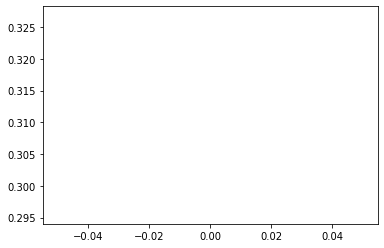

In [25]:
plt.plot(L(learn.recorder.values).itemgot(2));

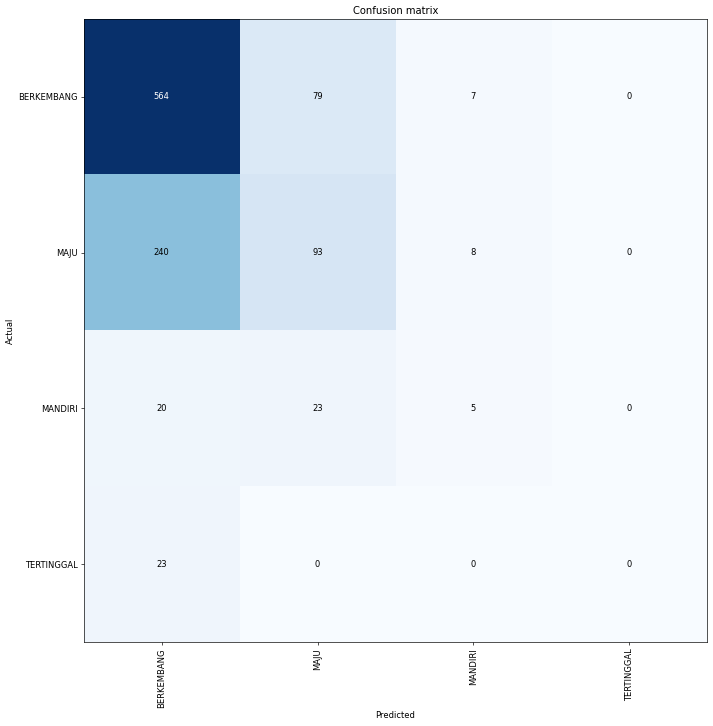

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [27]:
interp.most_confused(min_val=5)

[('MAJU', 'BERKEMBANG', 240),
 ('BERKEMBANG', 'MAJU', 79),
 ('MANDIRI', 'MAJU', 23),
 ('TERTINGGAL', 'BERKEMBANG', 23),
 ('MANDIRI', 'BERKEMBANG', 20),
 ('MAJU', 'MANDIRI', 8),
 ('BERKEMBANG', 'MANDIRI', 7)]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


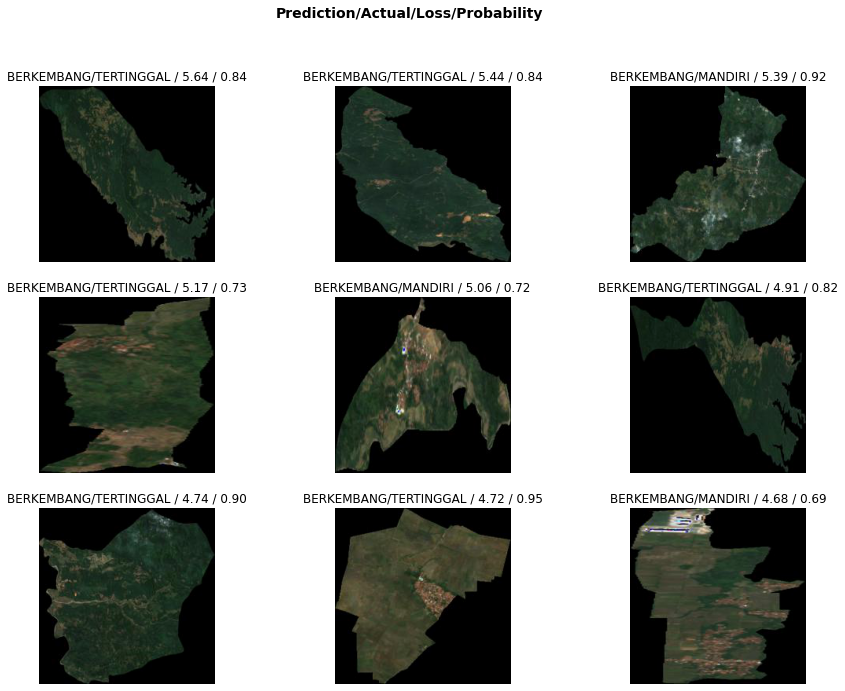

In [28]:
interp.plot_top_losses(16, figsize=(15,11))

### Imbalanced Dataset : Class merging

![image.png](attachment:bf222cb4-7a81-4542-b083-d0c31d1d67ea.png)

In [31]:
secondpath = "00. IDM Two Class Sentinel 10m TC"
path = Path.cwd() / (secondpath)

In [32]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(0.1,seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label) # data augmentation (mult multiplies the default transformation values)

dls = blocks.dataloaders(path)

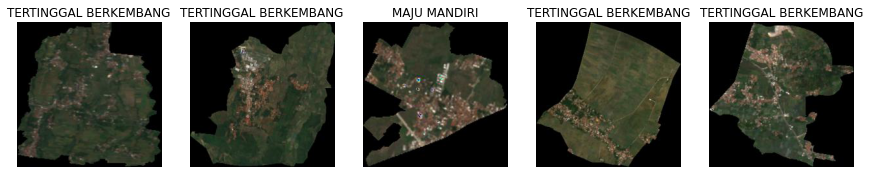

In [33]:
dls.show_batch(nrows=1, ncols=5)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.0014454397605732083)

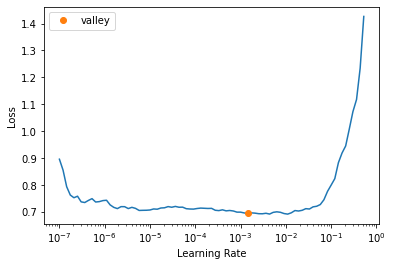

In [34]:
learn_second = cnn_learner(dls, densenet121, metrics=metricsc) 
learn.lr_find()

In [35]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_labels = L(dls.train.items).map(dls.tfms[1])
valid_labels = L(dls.valid.items).map(dls.tfms[1])
train_labels = train_labels +valid_labels
train_imgs = dls.train.items
tst_imgs = dls.valid.items
val_pct = []
tst_preds = []
test_lab = []
for train_idx, val_idx in kf.split(np.array(train_imgs+tst_imgs), train_labels):
    blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=IndexSplitter(val_idx),  # default random split 80% training, 20% validation
                 get_y=parent_label) # data augmentation (mult multiplies the default transformation values)
    dls = blocks.dataloaders(path)
    learn_second = vision_learner(dls, densenet121, metrics=metricsc) 
    learn_second.fit_one_cycle(4,1e-2)
    val_pct.append(learn_second.validate())
    tst_preds.append(learn_second.get_preds(ds_idx=1))


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.089136,0.934173,0.487300,0.549740,00:25
1,0.807270,0.698428,0.642521,0.594929,00:26
2,0.679031,0.636125,0.693321,0.599896,00:25
3,0.538922,0.625470,0.676388,0.622107,00:26


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.011587,0.773593,0.510358,0.558610,00:25
1,0.817369,0.718278,0.659134,0.648396,00:25
2,0.682782,0.589343,0.692090,0.628451,00:25
3,0.543045,0.582482,0.706215,0.657864,00:25


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.999430,0.683002,0.628060,0.546294,00:25
1,0.810309,0.674331,0.674200,0.598601,00:26
2,0.698372,0.601290,0.676083,0.597552,00:26
3,0.539515,0.613429,0.685499,0.622263,00:25


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.024851,0.722965,0.661017,0.561609,00:26
1,0.803082,0.751604,0.546139,0.556576,00:25
2,0.675689,0.615722,0.686441,0.608964,00:25
3,0.535645,0.645723,0.682674,0.623183,00:25


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.020071,0.770849,0.510358,0.520726,00:26
1,0.787947,0.709315,0.647834,0.561818,00:25
2,0.680782,0.675105,0.657250,0.561495,00:26
3,0.564147,0.660564,0.669492,0.606101,00:26


In [36]:
file_name = "/content/drive/MyDrive/Colab Notebooks/pickle predictions/01. cm imbalance.pkl"
with open(file_name, "wb") as fp:   #Pickling
   pickle.dump(tst_preds, fp)
pd.DataFrame(val_pct).to_csv("/content/drive/MyDrive/Colab Notebooks/validate/01. cm imbalance.csv")
pd.DataFrame(val_pct).mean()

0    0.625533
1    0.684053
2    0.626304
dtype: float64

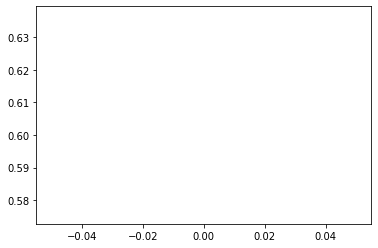

In [37]:
plt.plot(L(learn_second.recorder.values).itemgot(2));

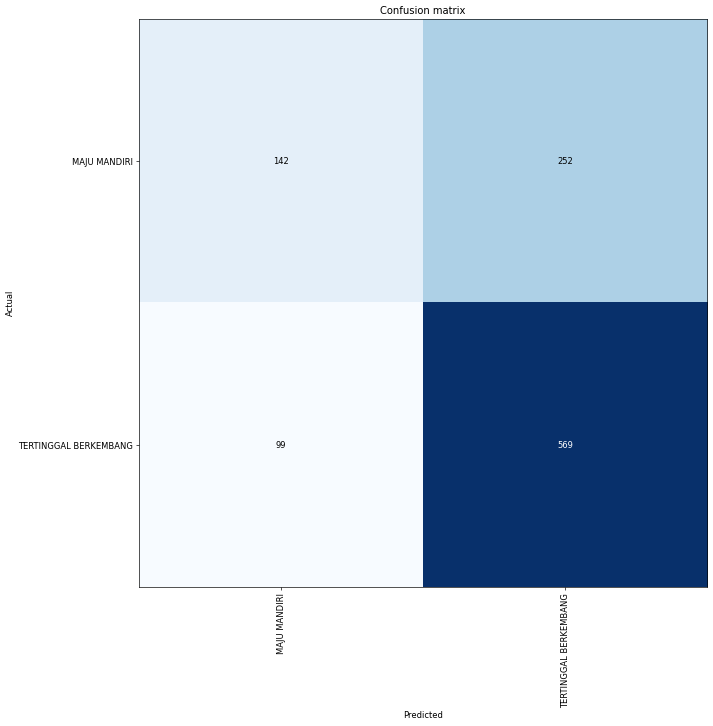

In [38]:
interp = ClassificationInterpretation.from_learner(learn_second)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Imbalanced Dataset : Weighting loss

![image.png](attachment:4e9c3b3d-d85d-4e38-9d9c-fade8c3e83a3.png)

In [ ]:
5312  /(4*3290) 

0.40364741641337387

In [ ]:
5312  /(4*1631) 

0.8142244022072348

In [ ]:
5312  /(4*270) 

4.9185185185185185

In [ ]:
5312  /(4*121) 

10.975206611570249

In [42]:
destpath = "00. Desa Sentinel 10m TC"

In [43]:
path = Path.cwd() / (destpath)

In [44]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(0.1,seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label) # data augmentation (mult multiplies the default transformation values)

dls = blocks.dataloaders(path,bs = 10)

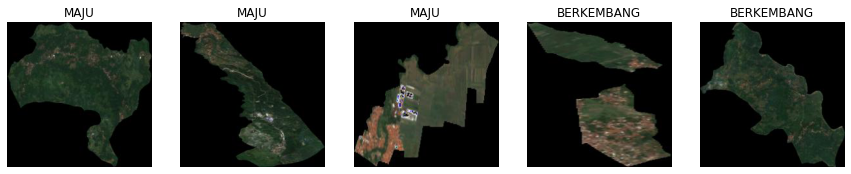

In [45]:
dls.show_batch(nrows=1, ncols=5)

In [46]:
class_weights=torch.FloatTensor([0.40364741641337387,0.8142244022072348,4.9185185185185185,10.975206611570249]).cuda()
new_loss = CrossEntropyLossFlat(weight=class_weights)

In [49]:
learn_third= vision_learner(dls, densenet121, metrics=metricsc,loss_func = new_loss) 

SuggestedLRs(valley=0.0014454397605732083)

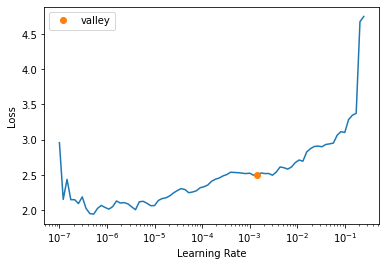

In [50]:
learn_third.lr_find()

In [51]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_labels = L(dls.train.items).map(dls.tfms[1])
valid_labels = L(dls.valid.items).map(dls.tfms[1])
train_labels = train_labels +valid_labels
train_imgs = dls.train.items
tst_imgs = dls.valid.items
val_pct = []
tst_preds = []
test_lab = []
for train_idx, val_idx in kf.split(np.array(train_imgs+tst_imgs), train_labels):
    blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=IndexSplitter(val_idx),  # default random split 80% training, 20% validation
                 get_y=parent_label) # data augmentation (mult multiplies the default transformation values)
    dls = blocks.dataloaders(path)
    learn_third = vision_learner(dls, densenet121, metrics=metricsc, loss_func = new_loss) 
    learn_third.fit_one_cycle(3,1e-3)
    val_pct.append(learn_third.validate())
    tst_preds.append(learn_third.get_preds(ds_idx=1))


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,2.306679,1.415363,0.452493,0.328892,00:25
1,1.720923,1.845809,0.269050,0.393679,00:25
2,1.241100,1.551861,0.357479,0.400278,00:25


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,2.216766,2.164310,0.201507,0.344198,00:26
1,1.685802,1.654629,0.349341,0.411430,00:25
2,1.227296,1.583117,0.346516,0.396061,00:26


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,2.310334,1.595768,0.340866,0.351013,00:26
1,1.741834,1.815866,0.312618,0.437550,00:25
2,1.262260,1.652497,0.323917,0.391411,00:26


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,2.272731,1.984534,0.225047,0.362453,00:26
1,1.761580,1.838326,0.305085,0.377597,00:25
2,1.278352,1.544650,0.369115,0.401140,00:25


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,2.129831,1.695995,0.346516,0.350528,00:26
1,1.688801,1.756584,0.310734,0.441230,00:26
2,1.208383,1.518816,0.362524,0.414921,00:25


In [52]:
file_name = "/content/drive/MyDrive/Colab Notebooks/pickle predictions/01. wc imbalance.pkl"
with open(file_name, "wb") as fp:   #Pickling
   pickle.dump(tst_preds, fp)
pd.DataFrame(val_pct).to_csv("/content/drive/MyDrive/Colab Notebooks/validate/01. wc imbalance.csv")
pd.DataFrame(val_pct).mean()

0    1.570188
1    0.351910
2    0.400762
dtype: float64

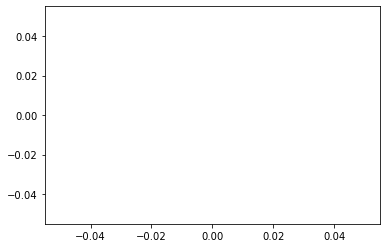

In [ ]:
plt.plot(L(learn_third.recorder.values).itemgot(2));

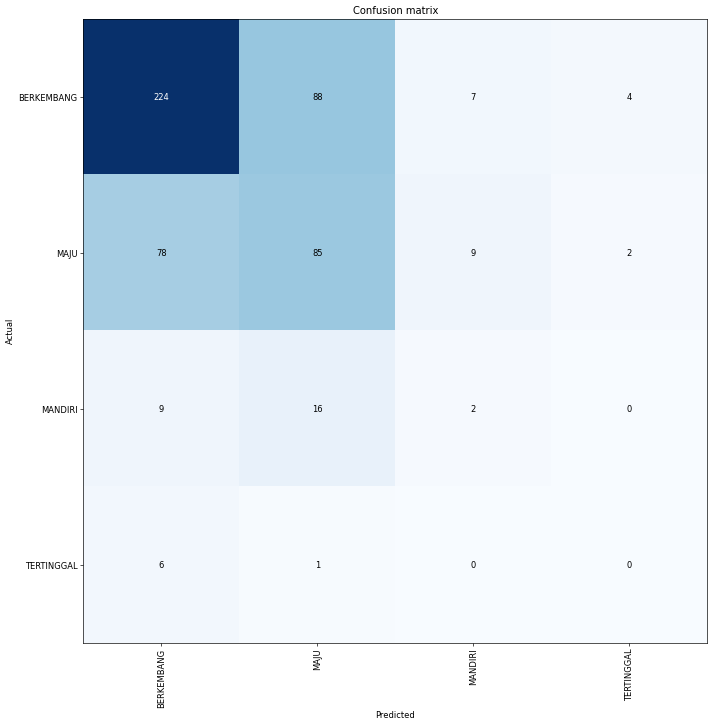

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_third)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Imbalanced Dataset : Oversampling Augmented

![image.png](attachment:af8dbbdf-f656-49bb-aabd-7d0e71b79cf3.png)

In [53]:
path = Path.cwd() / (destpath)

In [54]:
dls.train.items[4].parent

Path('BERKEMBANG')

In [55]:
def label_func(fname):
    return str(fname.parent)[(str(fname.parent).rfind("\\")+1):]

In [56]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(0.1,seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label) # data augmentation (mult multiplies the default transformation values)

dls = blocks.dataloaders(path,bs = 10)

In [57]:
def create_dataframe(data, label_func, is_valid=False):
    """
        Helper function to extract the dataframe from the DataLoaders
    """
    items = data.valid.items if is_valid else data.train.items
    labels = list(map(label_func, items))
    is_valid = [is_valid] * len(items)
    return pd.DataFrame({'items': items, 'label': labels, 'is_valid':is_valid})

In [58]:
# Data here is the Dataloaders object
# and label_func is the same used in the DataBlock
train_df = create_dataframe(dls, label_func, is_valid=False)
valid_df = create_dataframe(dls, label_func, is_valid=True)

train_df.head()

,items,label,is_valid
0,/content/00. Desa Sentinel 10m TC/BERKEMBANG/3203020010.jpg,/content/00. Desa Sentinel 10m TC/BERKEMBANG,False
1,/content/00. Desa Sentinel 10m TC/MAJU/3206061002.jpg,/content/00. Desa Sentinel 10m TC/MAJU,False
2,/content/00. Desa Sentinel 10m TC/BERKEMBANG/3206130008.jpg,/content/00. Desa Sentinel 10m TC/BERKEMBANG,False
3,/content/00. Desa Sentinel 10m TC/BERKEMBANG/3202131006.jpg,/content/00. Desa Sentinel 10m TC/BERKEMBANG,False
4,/content/00. Desa Sentinel 10m TC/BERKEMBANG/3207140005.jpg,/content/00. Desa Sentinel 10m TC/BERKEMBANG,False


In [60]:
train_df.groupby("label").count()

,items,is_valid
label,,
/content/00. Desa Sentinel 10m TC/BERKEMBANG,2967,2967
/content/00. Desa Sentinel 10m TC/MAJU,1453,1453
/content/00. Desa Sentinel 10m TC/MANDIRI,248,248
/content/00. Desa Sentinel 10m TC/TERTINGGAL,112,112


In [59]:
def oversample(frame: pd.DataFrame):
    max_size = frame['label'].value_counts().max()
    lst = [frame]
    for class_index, group in frame.groupby('label'):
        lst.append(group.sample(max_size-len(group), replace=True))
    return pd.concat(lst)

In [61]:
oversampled_train_df = oversample(train_df) # <------- TRAINING DATAFRAME ONLY
oversampled_train_df['label'].value_counts()

/content/00. Desa Sentinel 10m TC/BERKEMBANG    2967
/content/00. Desa Sentinel 10m TC/MAJU          2967
/content/00. Desa Sentinel 10m TC/TERTINGGAL    2967
/content/00. Desa Sentinel 10m TC/MANDIRI       2967
Name: label, dtype: int64

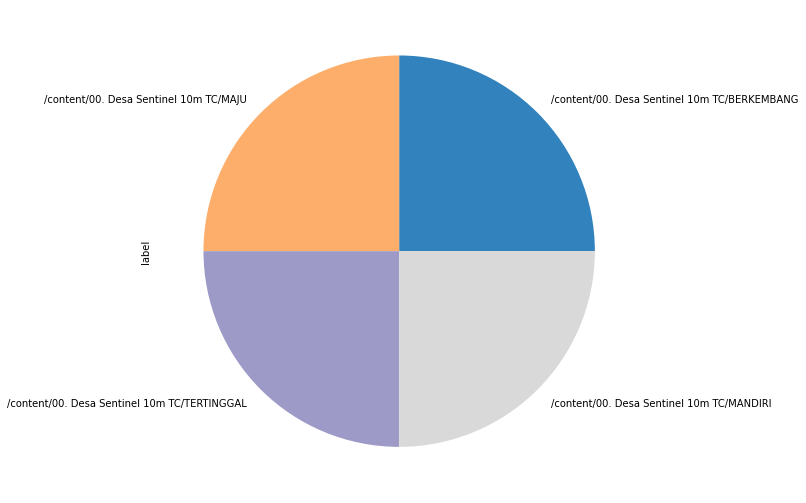

In [62]:
oversampled_train_df['label'].value_counts().plot.pie(cmap = "tab20c", figsize=(9, 9))

In [63]:
oversampled_df = pd.concat((oversampled_train_df, valid_df))
oversampled_df.head()

,items,label,is_valid
0,/content/00. Desa Sentinel 10m TC/BERKEMBANG/3203020010.jpg,/content/00. Desa Sentinel 10m TC/BERKEMBANG,False
1,/content/00. Desa Sentinel 10m TC/MAJU/3206061002.jpg,/content/00. Desa Sentinel 10m TC/MAJU,False
2,/content/00. Desa Sentinel 10m TC/BERKEMBANG/3206130008.jpg,/content/00. Desa Sentinel 10m TC/BERKEMBANG,False
3,/content/00. Desa Sentinel 10m TC/BERKEMBANG/3202131006.jpg,/content/00. Desa Sentinel 10m TC/BERKEMBANG,False
4,/content/00. Desa Sentinel 10m TC/BERKEMBANG/3207140005.jpg,/content/00. Desa Sentinel 10m TC/BERKEMBANG,False


In [64]:
new_dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
            get_x=ColReader(0), # Updated
            get_y=ColReader('label'), # Updated
            splitter  = ColSplitter(),
            batch_tfms=aug_transforms())

dls_os = new_dblock.dataloaders(oversampled_df,bs = 10)

SuggestedLRs(valley=0.0008317637839354575)

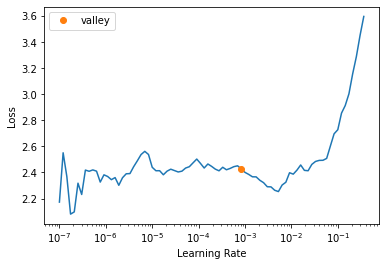

In [66]:
learn_four= vision_learner(dls_os, densenet121, metrics=metricsc) 
learn_four.lr_find()

In [71]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_labels = L(dls.train.items).map(dls.tfms[1])
valid_labels = L(dls.valid.items).map(dls.tfms[1])
train_labels = train_labels +valid_labels
train_imgs = dls.train.items
tst_imgs = dls.valid.items
val_pct = []
tst_preds = []
test_lab = []
for train_idx, val_idx in kf.split(np.array(train_imgs+tst_imgs), train_labels):
    blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=IndexSplitter(val_idx),  # default random split 80% training, 20% validation
                 get_y=parent_label) # data augmentation (mult multiplies the default transformation values)
    dls = blocks.dataloaders(path)
    train_df = create_dataframe(dls, label_func, is_valid=False)
    valid_df = create_dataframe(dls, label_func, is_valid=True)
    oversampled_train_df = oversample(train_df)
    oversampled_df = pd.concat((oversampled_train_df, valid_df))
    new_dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
            get_x=ColReader(0), # Updated
            get_y=ColReader('label'), # Updated
            splitter  = ColSplitter(),
            batch_tfms=aug_transforms())

    dls_os = new_dblock.dataloaders(oversampled_df)
    learn_four = vision_learner(dls_os, densenet121, metrics=metricsc) 
    learn_four.fit_one_cycle(2,1e-2)
    val_pct.append(learn_four.validate())
    tst_preds.append(learn_four.get_preds(ds_idx=1))

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.166154,1.587176,0.418627,0.398604,01:02
1,0.686380,1.140801,0.471308,0.371470,01:02


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.164978,1.320089,0.466102,0.418139,01:03
1,0.687949,1.178824,0.469868,0.418488,01:03


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.171977,1.223336,0.429379,0.428449,01:02
1,0.698695,1.170459,0.473635,0.411737,01:02


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.241914,1.630237,0.307910,0.461224,01:03
1,0.727920,1.090701,0.475518,0.409926,01:03


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.192508,1.588360,0.362524,0.407257,01:03
1,0.732865,1.125014,0.494350,0.425444,01:03


In [72]:
file_name = "/content/drive/MyDrive/Colab Notebooks/pickle predictions/01. oa imbalance.pkl"
with open(file_name, "wb") as fp:   #Pickling
   pickle.dump(tst_preds, fp)
pd.DataFrame(val_pct).to_csv("/content/drive/MyDrive/Colab Notebooks/validate/01. oa imbalance.csv")
pd.DataFrame(val_pct).mean()

0    1.141160
1    0.476936
2    0.407413
dtype: float64

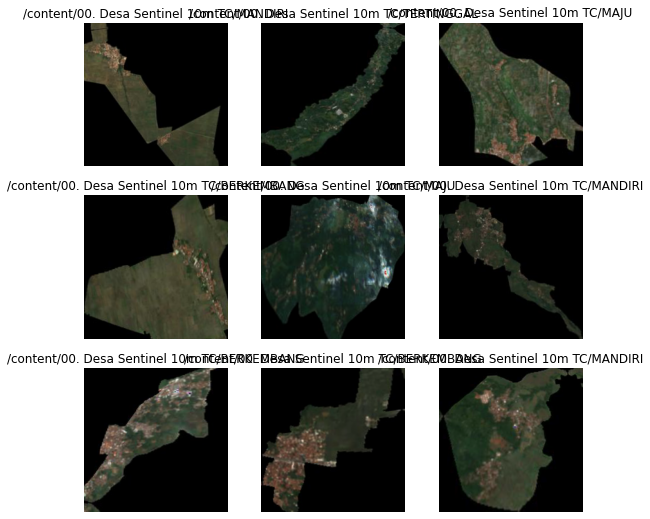

In [73]:
dls_os.show_batch()

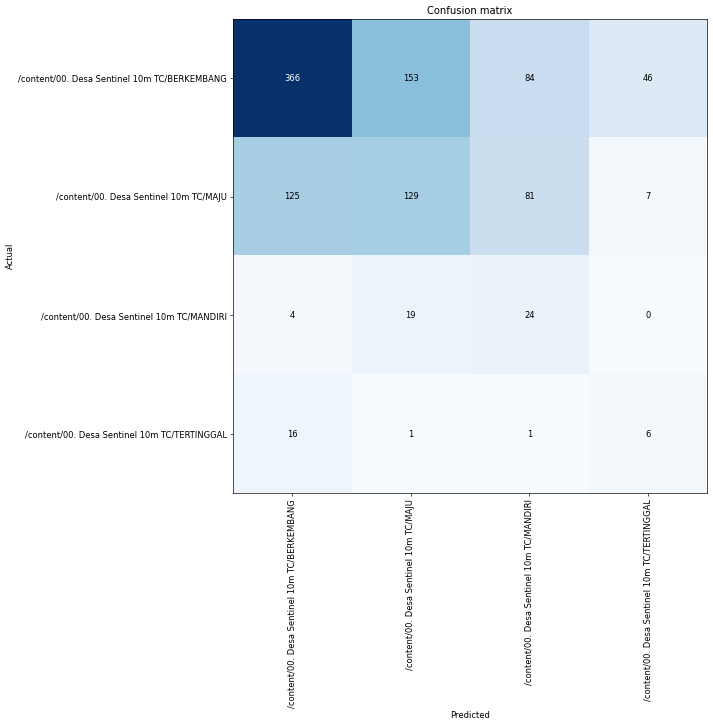

In [74]:
interp = ClassificationInterpretation.from_learner(learn_four)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)